In [1]:
import numpy as np
import matplotlib.pyplot as plt

from env import Env
from agent import Agent

# Initialise Environment

In [2]:
#initialise environment
workspace_lim = np.asarray([[-0.1 - 0.25, -0.1 + 0.25], 
                            [ 0.5 - 0.25,  0.5 + 0.25],
                            [         0.,        0.40]])
 
print(f"workspace_lim: {workspace_lim}")

obj_dir = 'objects/blocks/'
N_obj   = 1

env = Env(obj_dir = obj_dir, 
          N_obj   = N_obj,
          workspace_lim = workspace_lim)

workspace_lim: [[-0.35  0.15]
 [ 0.25  0.75]
 [ 0.    0.4 ]]
[SUCCESS] restart environment
[SUCCESS] setup rgbd camera
[SUCCESS] load obj paths
[SUCCESS] randomly choose objects
[SUCCESS] randomly choose object colors
object 0: shape_0, pose: [-0.16270772045110832, 0.630628266585735, 0.15, 5.782864994043495, 5.462294551956283, 2.047356342062193]
[SUCCESS] add objects to simulation


# Initialise Agent

In [3]:
agent = Agent(env)


[SUCCESS] initialise environment


/home/ryan/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torch/cuda/__init__.py:118: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1716905969824/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/ryan/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ryan/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=De

[SUCCESS] initialise networks
[SUCCESS] initialise memory buffer


# Testing

In [4]:
color_img, depth_img = agent.env.get_rgbd_data()

In [5]:
in_color_img, in_depth_img = agent.preprocess_input(color_img, depth_img)

In [6]:
print(in_color_img.shape)
print(in_depth_img.shape)

torch.Size([3, 224, 224])
torch.Size([3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..-1.8044444].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..2.0299783].


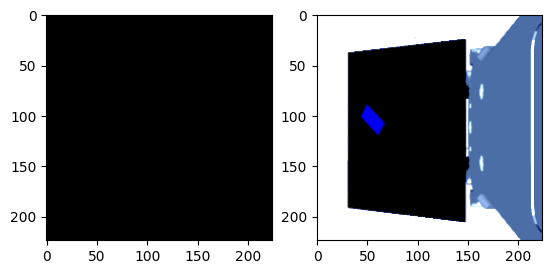

In [7]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(in_depth_img.permute((1,2,0)))
ax[1].imshow(in_color_img.permute((1,2,0)))
plt.show()

# test interact

In [8]:
agent.interact()

state.shape: torch.Size([1, 2048])
action_type: tensor([1]), action_type_probs: tensor([[0.3355, 0.3396, 0.3249]], grad_fn=<SoftmaxBackward0>), actions: tensor([[-0.0044,  0.0062, -0.0018,  0.0104,  0.0002, -0.0084]],
       dtype=torch.float64, grad_fn=<MulBackward0>)
